In [2]:
import numpy as np
import pandas as pd
import os
import sys
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

path = r"C:\Users\user\Victor\Trabajo\NoEstacionario\Python"
os.chdir(path)
os.getcwd()

'C:\\Users\\user\\Victor\\Trabajo\\NoEstacionario\\Python'

In [3]:
data = pd.read_table("Datos\\Hs_SS_PCs_FWT_LWT_Precip_Cantabria_reg_guided.txt")

In [4]:
# Columns for the Hs dataframe
cols_first = ['yyyy', 'mm', 'dd', 'Hs'] + [col for col in data.columns if col.startswith('PC') and not col.endswith('_SS')] + ['FWT']

# Columns for the Surge dataframe
cols_second = ['yyyy', 'mm', 'dd', 'Surge'] + [col for col in data.columns if col.endswith('_SS')] + ['LWT']

# Create the two DataFrames
df_hs = data[cols_first]
df_surge = data[cols_second]

In [5]:
# Define the days in a month dictionary
days_in_month = {1: 31, 2: 28.25, 3: 31, 4: 30, 5: 31, 6: 30, 7: 31, 8: 31, 9: 30, 10: 31, 11: 30, 12: 31}

# Correct the time assignment for df_hs
df_hs = df_hs.copy()  # Ensure it's a copy, avoiding modifying the original DataFrame slice
df_hs['time'] = (
    df_hs['yyyy'] - np.min(df_hs['yyyy'])
    + (df_hs['mm'] - 1) / 12
    + df_hs['dd'] / df_hs['mm'].map(days_in_month) / 12
)

# Correct the time assignment for df_surge
df_surge = df_surge.copy()  # Ensure it's a copy, avoiding modifying the original DataFrame slice
df_surge['time'] = (
    df_surge['yyyy'] - np.min(df_surge['yyyy'])
    + (df_surge['mm'] - 1) / 12
    + df_surge['dd'] / df_surge['mm'].map(days_in_month) / 12
)

In [6]:
# Hacemos positivos los valores negativos del SS
minimo_ss = np.abs(np.min(df_surge['Surge'].values))
df_surge['Surge'] += minimo_ss

In [7]:
np.sort(df_surge['Surge'].values)

array([0.        , 0.01275   , 0.016875  , ..., 0.704875  , 0.70854167,
       0.72795833])

# Análisis para SS por WT

In [8]:
wt_probs = df_surge['LWT'].value_counts(normalize=True).sort_index()
wt_range = np.sort(df_surge['LWT'].unique())

Diccionario con un DataFrame asociado a cada WT distinto.

In [9]:
dict_ss = {}
for idx_wt, wt in enumerate(wt_range):
    dict_ss[idx_wt] = df_surge[:][df_surge['LWT'] == idx_wt]

In [10]:
# Yearly maxima
hsmax_data = {}
max_idx = {}

for idx_wt, wt in enumerate(wt_range):
    hsmax_data[idx_wt] = dict_ss[idx_wt].groupby(["yyyy"], as_index=False)["Surge"].max()  # Máximo anual Hs para cada WT
    max_idx[idx_wt] = dict_ss[idx_wt].groupby(["yyyy"])["Surge"].idxmax().values           # Indice del máximo anual por WT
n_return_period = 365.25

In [11]:
n_return_period = 365.25*wt_probs

Datos ordenados

In [12]:
hsmax_data_sorted = {}
sorted_max_idx = {}
for idx_wt, wt in enumerate(wt_range):
    hsmax_data_sorted[idx_wt] = np.sort(hsmax_data[idx_wt]['Surge'])
    sorted_max_idx[idx_wt] = np.argsort(hsmax_data[idx_wt]['Surge'])

Point-in-time data

In [13]:
hspt = {}
hspt_sort = {}
# Hs point-in-time data per WT
for idx_wt, wt in enumerate(wt_range):
    hspt[idx_wt] = dict_ss[idx_wt]['Surge'].values
    hspt_sort[idx_wt] = np.sort(dict_ss[idx_wt]['Surge'].values)

Cálculo de las ECDF y el periodo de retorno para cada WT

In [14]:
ecdf_pt_probs= {}
T_pt = {}
ecdf_ev_probs_wt = {}
T_ev_wt = {}

for idx_wt, wt in enumerate(wt_range):
    # Empirical df and Return period for point in time
    ecdf_pt_probs[idx_wt] = np.arange(1,len(hspt[idx_wt])+1)/(len(hspt[idx_wt])+1)
    T_pt[idx_wt] = 1/(1-ecdf_pt_probs[idx_wt])/n_return_period[idx_wt]

    # Empirical df and Return period for monthly maxima
    ecdf_ev_probs_wt[idx_wt] = np.arange(1,len(hsmax_data[idx_wt])+1)/(len(hsmax_data[idx_wt])+1)
    T_ev_wt[idx_wt] = 1/(1-ecdf_ev_probs_wt[idx_wt])

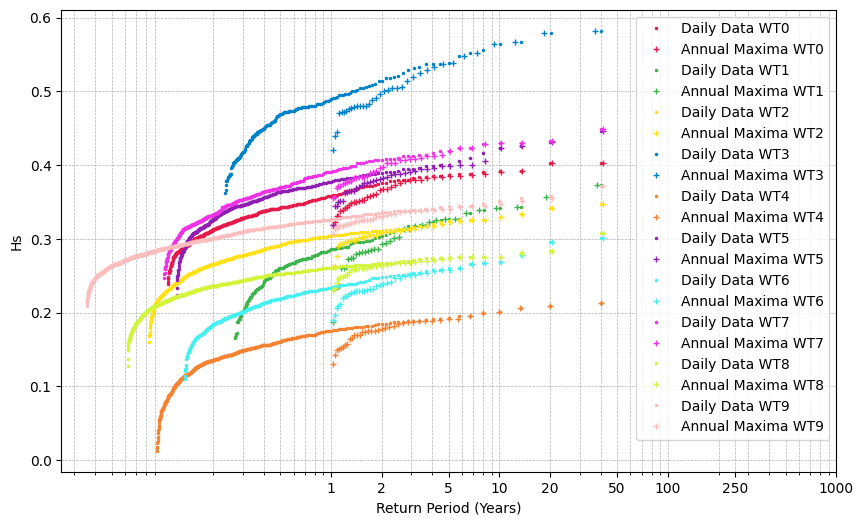

In [15]:
colors = [
    '#e6194b', '#3cb44b', '#ffe119', '#0082c8', '#f58231', '#911eb4',
    '#46f0f0', '#f032e6', '#d2f53c', '#fabebe', '#008080', '#e6beff',
    '#aa6e28', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1',
    '#000080', '#808080', '#ffffff', '#000000', '#ff0000', '#00ff00',
    '#0000ff', '#ffff00', '#ff00ff', '#00ffff', '#800080', '#ff4500',
    '#8b0000', '#008000', '#4682b4', '#d2691e', '#ff1493', '#6495ed'
]


fig = plt.figure(figsize=(10,6))
ax= fig.add_subplot()
for idx_wt in range(10):
    ax.semilogx(T_pt[idx_wt], hspt_sort[idx_wt], linewidth=0, color=colors[idx_wt], marker='o',markersize=1.5, label=f'Daily Data WT{idx_wt}')
    ax.semilogx(T_ev_wt[idx_wt], hsmax_data_sorted[idx_wt], color=colors[idx_wt], linewidth=0, marker='+',markersize=5, label=f'Annual Maxima WT{idx_wt}')

# Configurar escala logarítmica y ticks personalizados
ax.set_xscale('log')
ax.set_xticks([1, 2, 5, 10, 20, 50, 100, 250, 1000])
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())  # Mantiene los números sin notación científica

# Etiquetas y grid
ax.set_xlabel('Return Period (Years)')
ax.set_ylabel('Hs')
ax.grid(True, which="both", linestyle="--", linewidth=0.5)

# Mostrar gráfico
plt.legend()
plt.show()

# Corrección Extremos en Bloques usando la clase ya creada

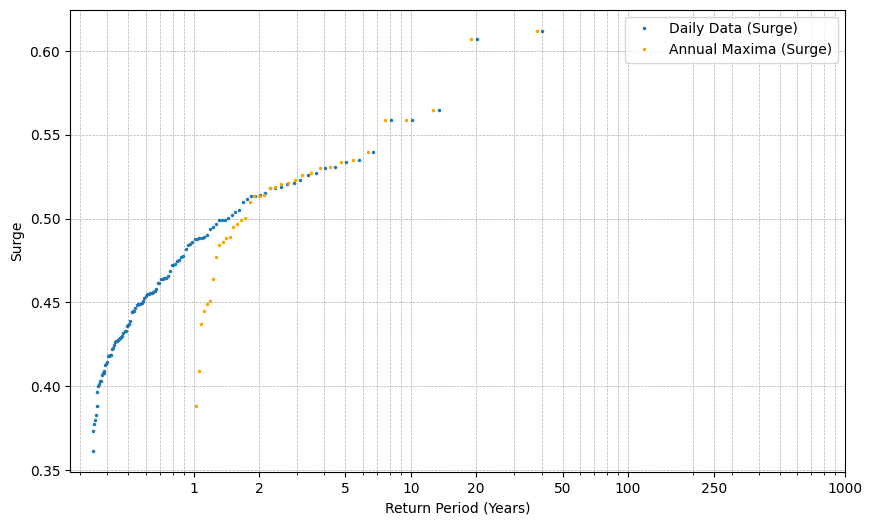

C:\Users\user\Victor\Trabajo\NoEstacionario\Python\ExtremePOT_Correction\extremecorrection.py:135: RuntimeWarning: divide by zero encountered in divide
  return_perd_values_gev = 1/(1-stats.genextreme.cdf(x_values_gev,self.gev_parameters[2], loc=self.gev_parameters[0], scale=self.gev_parameters[1]))


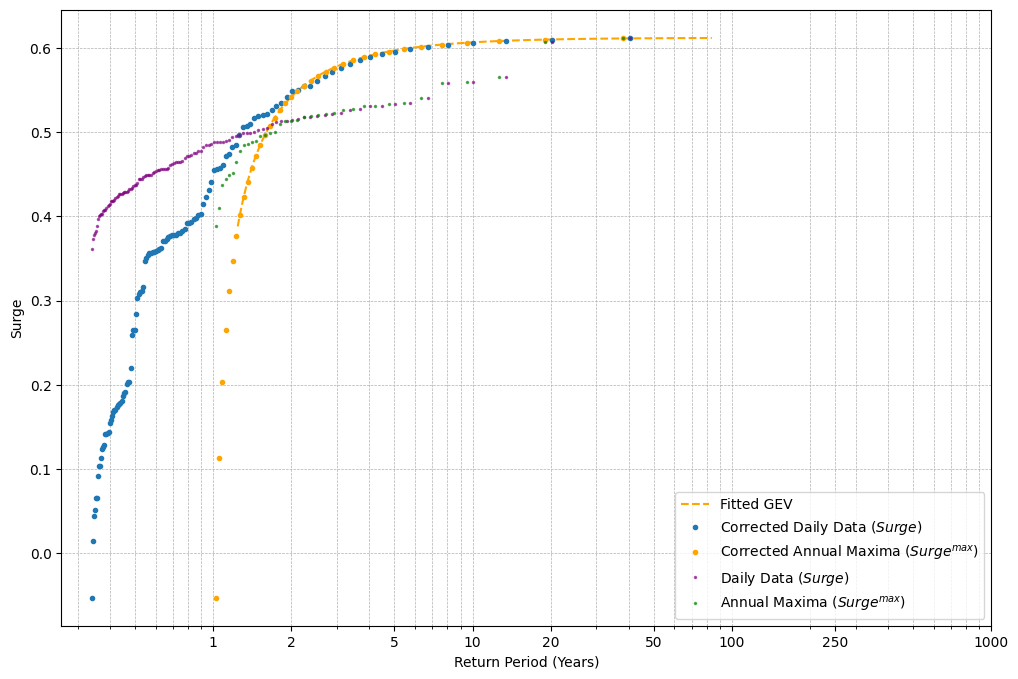

In [16]:
from ExtremePOT_Correction.extremecorrection import ExtremeCorrection

# for idx_wt, wt in enumerate(wt_range):
idx_wt=35
extremecorr = ExtremeCorrection(dict_ss[idx_wt], data_var='Surge', frequency=n_return_period[idx_wt])
extremecorr.return_period_plot()

output_dir = "Figuras/SS/CorrectionMax_WT_SS"
os.makedirs(output_dir, exist_ok=True)

fig = extremecorr.return_period_plot_corrected(without_corr=True)  # Generar gráfico

fig.savefig(f"{output_dir}/ReturnPeriod_WT{idx_wt}.png", dpi=200, bbox_inches='tight')
# extremecorr.plot_ts()

# Ajuste de Pareto-Poisson a cada WT

## Selección del threshold óptimo

In [17]:
from OptimalThresholdSelection.optimal_threshold_studentized import OptimalThreshold

### Selección del umbral óptimo para los datos completos sin división por WT

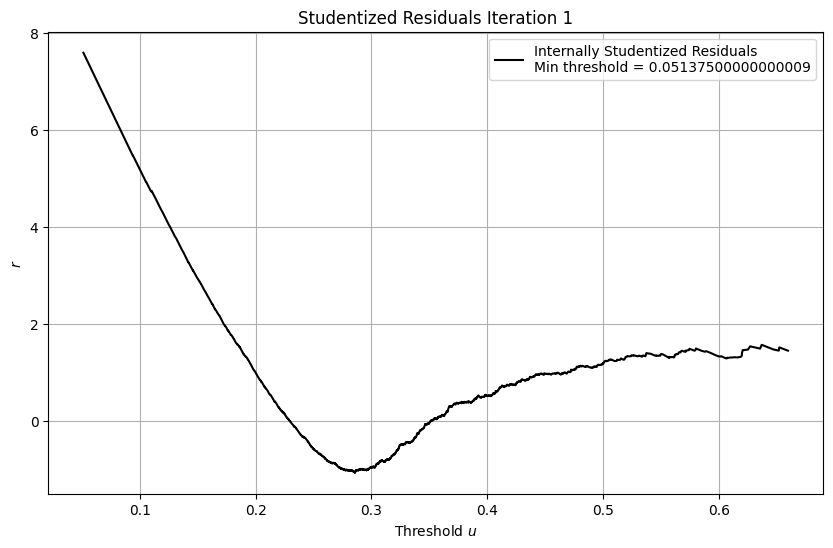

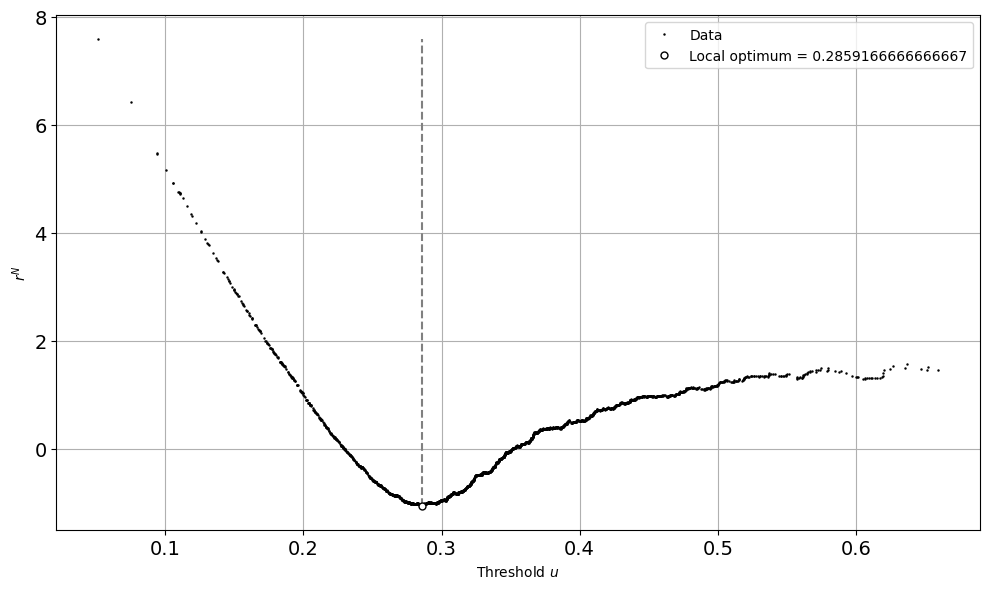

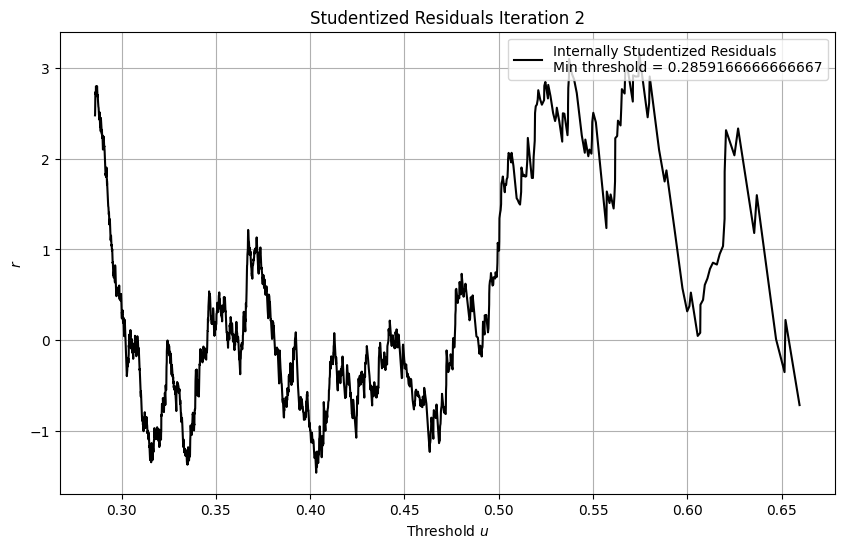

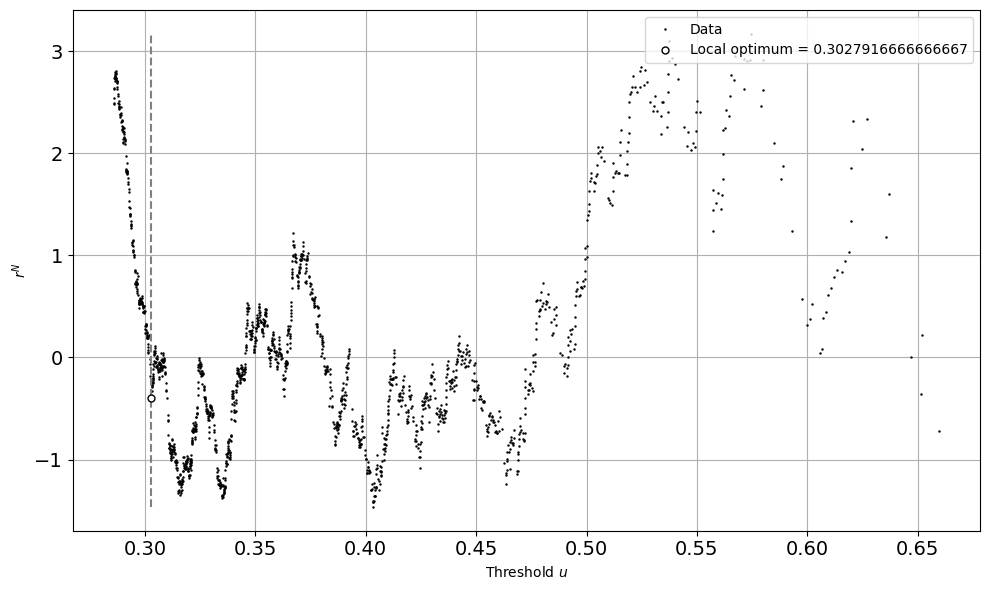

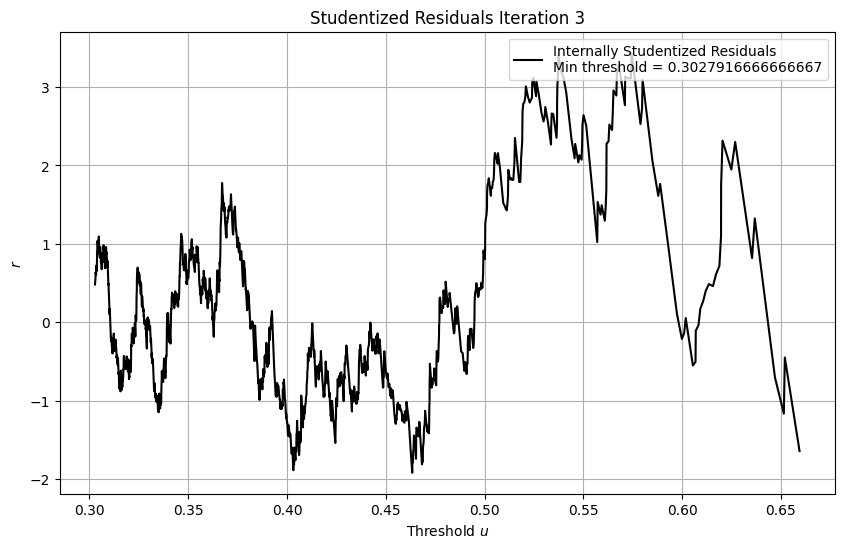

[0.30279167]


In [18]:
threshold = 0.0
n0 = 10
min_peak_distance = 2   # 2 días de distancia entre picos
siglevel=0.05

# Inicializar la clase
opt_thres = OptimalThreshold(data=df_surge['Surge'].values)
# Obtener los picos
opt_thres.threshold_peak_extraction(threshold=0,
                                    n0=n0,
                                    min_peak_distance=min_peak_distance)

# Crear carpeta si no existe
folder_path = "Figuras/SS/"
os.makedirs(folder_path, exist_ok=True)

# Obtener el threshold óptimo
threshold = opt_thres.threshold_studentized_residuals(siglevel=siglevel,
                                                      plot_flag=True,
                                                      filename=f"{folder_path}Optimal_Threshold_Surge",
                                                      display_flag=False)
print(threshold)

### Selección del threshold óptimo para cada WT

Primero dividimos los datos por WT y le asignamos el valor 0 a los datos en los que no aparezca ese WT

In [19]:
# Copiar solo las columnas PC0,..., PC99 y 'time' del DataFrame original
cols_pc = [col for col in df_surge.columns if col.startswith("PC")] + ['time', 'LWT']
df_rwt = df_surge[cols_pc].copy()

# Obtener valores únicos de RWT
unique_rwt = df_surge['LWT'].unique()

# Crear nuevas columnas Hs_RWT0, Hs_RWT1, ..., Hs_RWTn
for wt in unique_rwt:
    df_rwt[f'SS_RWT{int(wt)}'] = df_surge['Surge'].where(df_surge['LWT'] == wt, 0)

#### Obtenemos el threshold óptimo para cada WT usando la clase creada

In [20]:
thresholds = np.min(np.sort(df_surge['Surge'].values))*np.ones(len(wt_range))
picos = {}
pks = {}
n0 = 10
min_peak_distance = 2   # 2 días de distancia entre picos
siglevel = 0.05         # Nivel de confianza

for wt in unique_rwt[:]:
    # print(wt)
    # Inicializar la clase
    opt_thres = OptimalThreshold(data=df_rwt[f'SS_RWT{int(wt)}'].values)
    # Obtener los picos
    opt_thres.threshold_peak_extraction(threshold=thresholds[wt],
                                        n0=n0,
                                        min_peak_distance=min_peak_distance)
    
    #picos[wt] = opt_thres.pks_unicos_valid
    picos[wt] = np.sort(opt_thres.pks)
    # Obtener el threshold óptimo
    thresholds[wt] = opt_thres.threshold_studentized_residuals(siglevel=siglevel).item()

In [21]:
thresholds

array([0.31316667, 0.25991667, 0.25904167, 0.47075   , 0.12583333,
       0.31416667, 0.17854167, 0.31325   , 0.2205    , 0.27770833,
       0.53366667, 0.36804167, 0.34925   , 0.33258333, 0.408125  ,
       0.19066667, 0.47516667, 0.24033333, 0.31820833, 0.424125  ,
       0.16654167, 0.26866667, 0.42408333, 0.22254167, 0.212375  ,
       0.26966667, 0.27133333, 0.48508333, 0.36429167, 0.32658333,
       0.22008333, 0.22879167, 0.32279167, 0.31683333, 0.115375  ,
       0.44479167])

In [22]:
poisson_parameter = np.zeros(len(wt_range))
for wt in unique_rwt[:]:
    poisson_parameter[wt] = len(picos[wt][picos[wt]>thresholds[wt]])/40

In [23]:
poisson_parameter

array([ 4.1  ,  1.75 ,  4.925,  1.575,  4.25 ,  4.425,  4.   ,  6.425,
        6.475,  8.95 ,  1.325,  3.225,  2.725,  2.175,  3.625,  7.675,
        0.85 ,  2.175,  3.3  ,  2.675,  3.775, 10.05 ,  3.8  ,  7.825,
        4.575,  5.225, 10.575,  2.225,  4.4  ,  7.075,  2.05 ,  4.175,
        0.375,  1.9  ,  2.675,  1.675])

#### Ajuste de Pareto para cada WT

In [24]:
from scipy.stats import genpareto

In [25]:
xi = np.zeros(len(wt_range))
loc = np.zeros(len(wt_range))
sigma = np.zeros(len(wt_range))

for wt in unique_rwt[:]:
    xi[wt], loc[wt], sigma[wt] = genpareto.fit(picos[wt][picos[wt]>thresholds[wt]]-thresholds[wt], floc=0)

### Corrección Extremal para cada WT

In [26]:
def qgpd(prob,threshold,xi,sigma):
    return genpareto.ppf(prob, c=xi, loc=threshold, scale=sigma)

In [27]:
# Defining dictionary to store all the data for differents WT
ecdf_pot_probs = {}
hs_pot_wt0_corrected = {}
hs_wt0_corrected = {}
ecdf_pot_probs_corrected ={}
T_ev_corrected = {}
ecdf_pt_probs_corrected = {}
T_pt_corrected = {}
x_values_gpd = {}
fitted_return_perd_values_gpd = {}
T_pot = {}
ecdf_pt_probs_wt = {}
T_pt_wt = {}

# Correction loop
for wt in unique_rwt[:]:
    # Probabilidades empíricas de los picos 
    ecdf_pot_probs[wt] = np.arange(1,len(picos[wt][picos[wt]>thresholds[wt]])+1)/(len(picos[wt][picos[wt]>thresholds[wt]])+1)
    # Picos corregidos
    hs_pot_wt0_corrected[wt] = qgpd(ecdf_pot_probs[wt], thresholds[wt], xi[wt], sigma[wt])

    # Corrección de los datos diarios
    hs_wt0_corrected[wt] = dict_ss[wt]['Surge'].values.copy()
    for block_idx, max_value in enumerate(picos[wt][picos[wt]>thresholds[wt]]):
        if block_idx >= len(picos[wt][picos[wt]>thresholds[wt]])-1:
            hs_wt0_corrected[wt][dict_ss[wt]['Surge'].values >= picos[wt][picos[wt]>thresholds[wt]][-1]] = hs_pot_wt0_corrected[wt][-1]
            break
        else:
            for idx, daily_value in enumerate(dict_ss[wt]['Surge'].values):
                if daily_value >= picos[wt][picos[wt]>thresholds[wt]][block_idx] and daily_value < picos[wt][picos[wt]>thresholds[wt]][block_idx+1]:
                    hs_wt0_corrected[wt][idx] = hs_pot_wt0_corrected[wt][block_idx]+((daily_value-picos[wt][picos[wt]>thresholds[wt]][block_idx])/(picos[wt][picos[wt]>thresholds[wt]][block_idx+1]-picos[wt][picos[wt]>thresholds[wt]][block_idx]))*(hs_pot_wt0_corrected[wt][block_idx+1]-hs_pot_wt0_corrected[wt][block_idx])


    # Calculo de probabilidades y periodos de retorno
    x_values_gpd[wt] = np.linspace(picos[wt][picos[wt] >thresholds[wt]][0], picos[wt][picos[wt] >thresholds[wt]][-1], 1000)
    fitted_return_perd_values_gpd[wt] = 1/(1-genpareto.cdf(x_values_gpd[wt], c=xi[wt], loc=thresholds[wt], scale=sigma[wt]))/poisson_parameter[wt]

    ecdf_pot_probs_corrected[wt] = genpareto.cdf(qgpd(ecdf_pot_probs[wt], xi=xi[wt], threshold=thresholds[wt], sigma=sigma[wt]), c=xi[wt], loc=thresholds[wt], scale=sigma[wt])
    T_ev_corrected[wt] = 1/(1-ecdf_pot_probs_corrected[wt])/poisson_parameter[wt]   # Se divide entre el nºmedio de POTs ocurrencias por WT 

    ecdf_pt_probs_corrected[wt] = np.arange(1,len(hs_wt0_corrected[wt])+1)/(len(hs_wt0_corrected[wt])+1)
    T_pt_corrected[wt] = 1/(1-ecdf_pt_probs_corrected[wt])/n_return_period[wt]      # Se divide entre la probabilidad de ocurrencia de ese WT
    
    # POT sin corregir
    T_pot[wt] = 1/(1-ecdf_pot_probs[wt])/poisson_parameter[wt]      # Se divide entre el nºmedio de ocurrencias de ese POT por WT 

    # Daily data sin corregir
    ecdf_pt_probs_wt[wt] = np.arange(1,len(dict_ss[wt]['Surge'].values)+1)/(len(dict_ss[wt]['Surge'].values)+1)
    T_pt_wt[wt] = 1/(1-ecdf_pt_probs_wt[wt])/n_return_period[wt]    # Se divide entre la probabilidad de ocurrencia de ese WT

In [28]:
weather_type = 0
# Gráfico
for weather_type in unique_rwt[:]:
    fig = plt.figure(figsize=(12,8))
    ax= fig.add_subplot()
    ax.semilogx(fitted_return_perd_values_gpd[weather_type], np.sort(x_values_gpd[weather_type])-minimo_ss, color = 'orange',linestyle='dashed', label='Fitted GPD')
    ax.semilogx(T_pt_corrected[weather_type], np.sort(hs_wt0_corrected[weather_type])-minimo_ss, linewidth=0, marker='o',markersize=3, label='Corrected Daily Data ($SS$)')
    ax.semilogx(T_ev_corrected[weather_type], qgpd(ecdf_pot_probs[weather_type], xi=xi[weather_type], threshold=thresholds[weather_type], sigma=sigma[weather_type])-minimo_ss, color = 'orange',linewidth=0, marker='o',markersize=3, label=r'Corrected POT ($SS$)')

    # Si representamos los datos sin corregir
    ax.semilogx(T_pot[weather_type], picos[weather_type][picos[weather_type] > thresholds[weather_type]]-minimo_ss, color="green", linewidth=0, marker='+',markersize=3, label='POT')
    ax.semilogx(T_pt_wt[weather_type], np.sort(dict_ss[weather_type]['Surge'].values)-minimo_ss, color="purple", linewidth=0, marker='+',markersize=3, label='Daily Data')


    ax.set_xlabel("Return Periods (Years)")
    ax.set_ylabel("SS")
    ax.set_xscale('log')
    ax.set_xticks([1, 2, 5, 10, 20, 50, 100, 250, 1000])
    ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
    ax.legend()
    ax.grid()
    plt.savefig(f"Figuras/SS/CorrectionPOT_WT_SS/ReturnPeriod_{wt}.png", dpi=300)
    plt.close()

## Máximos anuales corregidos con Pareto-Poisson

In [29]:
def q_pareto_poisson(ret_period, threshold, xi, sigma, lam, wt):
    if np.abs(xi[wt]) < 1e-8:
        out = threshold[wt] + sigma[wt]*np.log(lam[wt]*ret_period)
    else:
        out = threshold[wt] + sigma[wt]/xi[wt]*((-np.log(1-1/ret_period)/lam[wt])**(-xi[wt])-1)
    return out

In [ ]:
# Defining dictionaries
new_max_idx = {}
annual_maxima_corrected = {}
annual_maxima_corrected_sorted = {}
ecdf_annual_maxima = {}
T_ecdf_annual_maxima = {}
adjusted_quantiles_for_maxima = {}

for wt in unique_rwt[:]:
    # Indices para los máximos corregidos
    new_max_idx[wt] = dict_ss[wt]['Surge'].index.get_indexer(max_idx[wt])

    annual_maxima_corrected[wt] = hs_wt0_corrected[wt][new_max_idx[wt]]
    annual_maxima_corrected_sorted[wt] = np.sort(annual_maxima_corrected[wt])
    ecdf_annual_maxima[wt] = np.arange(1,len(annual_maxima_corrected_sorted[wt])+1)/(len(annual_maxima_corrected_sorted[wt])+1)
    T_ecdf_annual_maxima[wt] = 1/(1-ecdf_annual_maxima[wt])*(40/len(annual_maxima_corrected[wt]))   # Se divide por la proporción de años en los que aparece ese WT (nºde años que aparece / nºaños registro)
    adjusted_quantiles_for_maxima[wt] = q_pareto_poisson(T_ecdf_annual_maxima[wt], threshold=thresholds, xi=xi, sigma=sigma, lam=poisson_parameter, wt=wt)

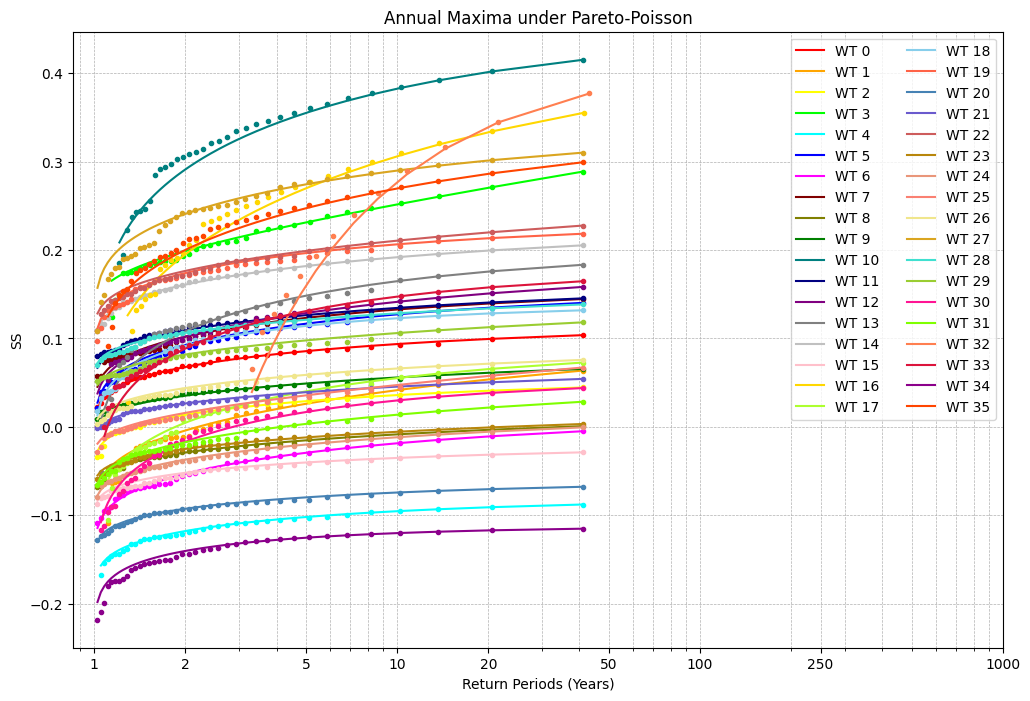

In [31]:
fig = plt.figure(figsize=(12,8))
ax= fig.add_subplot()

colors = [
    "#FF0000", "#FFA500", "#FFFF00", "#00FF00", "#00FFFF", "#0000FF", "#FF00FF", "#800000", 
    "#808000", "#008000", "#008080", "#000080", "#800080", "#808080", "#C0C0C0", "#FFC0CB", 
    "#FFD700", "#ADFF2F", "#87CEEB", "#FF6347", "#4682B4", "#6A5ACD", "#CD5C5C", "#B8860B", 
    "#E9967A", "#FA8072", "#F0E68C", "#DAA520", "#40E0D0", "#9ACD32", "#FF1493", "#7FFF00", 
    "#FF7F50", "#DC143C", "#8B008B", "#FF4500"
    ]
for wt in np.sort(unique_rwt[:]):
    ax.semilogx(T_ecdf_annual_maxima[wt], annual_maxima_corrected_sorted[wt]-minimo_ss, color = colors[wt], linewidth=0, marker='o',markersize=3)
    ax.semilogx(T_ecdf_annual_maxima[wt], adjusted_quantiles_for_maxima[wt]-minimo_ss, color = colors[wt], label=f'WT {wt}')


ax.set_xlabel("Return Periods (Years)")
ax.set_ylabel("SS")
ax.set_xscale('log')
ax.set_xticks([1, 2, 5, 10, 20, 50, 100, 250, 1000])
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
ax.legend(ncol=2)
ax.grid(True, which="both", linestyle="--", linewidth=0.5)
ax.set_title("Annual Maxima under Pareto-Poisson")
plt.savefig(f"Figuras/SS/AnnMax_ReturnPeriod_All_SS.png", dpi=300)
plt.show()

#### Gráficos Completos

In [32]:
folder_path = "Figuras/SS/CompleteReturnPeriods_SS"
os.makedirs(folder_path, exist_ok=True)

for wt in np.sort(unique_rwt[:]):
    
    fig = plt.figure(figsize=(12,8))
    ax= fig.add_subplot()   

    ax.semilogx(fitted_return_perd_values_gpd[wt], np.sort(x_values_gpd[wt])-minimo_ss, color = 'orange',linestyle='dashed', label='Adjusted GPD')
    ax.semilogx(T_pt_corrected[wt], np.sort(hs_wt0_corrected[wt])-minimo_ss, linewidth=0, marker='o',markersize=3, label='Corrected Daily Data ($SS$)')
    ax.semilogx(T_ev_corrected[wt], qgpd(ecdf_pot_probs[wt], xi=xi[wt], threshold=thresholds[wt], sigma=sigma[wt])-minimo_ss, color = 'orange',linewidth=0, marker='o',markersize=3, label=r'Corrected POT ($SS$)')

    # Si representamos los datos sin corregir
    # ax.semilogx(T_pot[wt], picos[wt][picos[wt] > thresholds[wt]], color="green", linewidth=0, marker='+',markersize=3, label='POT')
    # ax.semilogx(T_pt_wt[wt], np.sort(dict_hs[wt]['Hs'].values), color="purple", linewidth=0, marker='+',markersize=3, label='Daily Data')

    # Annual Return Periods
    ax.semilogx(T_ecdf_annual_maxima[wt], annual_maxima_corrected_sorted[wt]-minimo_ss, color = "#FF0000", linewidth=0, marker='o',markersize=3, label=r'Corrected Annual Maxima')
    ax.semilogx(T_ecdf_annual_maxima[wt], adjusted_quantiles_for_maxima[wt]-minimo_ss, color = "#FF0000",linestyle='dashed', label=f'Adjusted GPD-Poisson')


    ax.set_xlabel("Return Periods (Years)")
    ax.set_ylabel("SS")
    ax.set_xscale('log')
    ax.set_xticks([1, 2, 5, 10, 20, 50, 100, 250, 1000])
    ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
    ax.legend(ncol=2)
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    # ax.set_title("Annual Maxima under Pareto-Poisson")
    plt.savefig(f"{folder_path}/ReturnPeriod_{wt}.png", dpi=300)
    plt.close()
    # plt.show()

# Ajuste extremal con covariables

In [33]:
annual_max_idx = df_hs.groupby(["yyyy", "FWT"])["Hs"].idxmax().values
# annual_max_idx = df_hs.groupby(["yyyy"])["Hs"].idxmax().values

PC_list = []
for i in range(100):
    PC_list.append(f"PC{i}")

In [ ]:
from Daily_Hs_StormSurge_ScipyJax.non_stationary_model import NonStationaryModel
import jax.numpy as jnp
import time

xt = df_hs.loc[annual_max_idx,'Hs'].values
t = df_hs.loc[annual_max_idx,'time'].values

# 1. Definición de los datos
xt=jnp.array(xt)
t =jnp.array(t)

# Parámetros iniciales
n_harmonics_loc = 1     # Número de armónicos para ubicación
n_harmonics_scale = 1   # Número de armónicos para escala
n_harmonics_shape = 1   # Número de armónicos para forma
betaT = 0               # Tendencia en localización
betaT2 = 0              # Tendencia en escala
# rhocoeff = 6000  # Coeficiente de penalización Lasso

model_lasso2 = NonStationaryModel(
    xt=xt,
    t=t,
    covariates_loc=jnp.asarray(df_hs.loc[annual_max_idx,PC_list].values),
    covariates_sc=jnp.asarray(df_hs.loc[annual_max_idx,PC_list].values),
    covariates_sh=jnp.empty((len(xt),0)),
    n_harmonics_loc=n_harmonics_loc,
    n_harmonics_scale=n_harmonics_scale,
    n_harmonics_shape=n_harmonics_shape,
    betaT=betaT,
    betaT2=betaT2,
    #rhocoeff=rhocoeff,
    regularization_type="lasso",
    example='Monthly Maxima Hs'
)

In [ ]:
print("Ajustando modelo con regularización Lasso...")
# Iniciar el temporizador
start_time = time.time()
result_lasso = model_lasso2.fit(rhocoeff=20, method='lbfgsb', maxiter=1000, linesearch='zoom')  # linesearch='hager-zhang', 'zoom', 'backtracking'
# Detener el temporizador
end_time = time.time()
# Calcular el tiempo transcurrido
elapsed_time = end_time - start_time
print(f"Tiempo de ejecución L-BFGS-B Grid Search con lasso: {elapsed_time:.2f} segundos")
print("Ajuste completado.\n")

# 9. Obtener y mostrar parámetros ajustados para Lasso
print(f"Valor óptimo de verosimilitud: {result_lasso['loglik']}")
print("\nParámetros ajustados con Lasso:")
model_lasso2.summary()

final_parameters = result_lasso['params']

model_lasso2.PPplot()
model_lasso2.QQplot()